# MAP5935 - Statistical Learning (Chapter 4 - Classification)

**Prof. Christian Jäkel**

https://www.statlearning.com/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

In [2]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA ,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## *Conceptual Exercises*

### (6) Suppose we collect data for a group of students in a statistics class with variables $X1$ = hours studied, $X2$ = undergrad GPA, and $Y$ = receive an A. We fit a logistic regression and produce estimated coefficient, $\hat{\beta}_0=-6$, $\hat{\beta}_1=0.05$, $\hat{\beta}_2=1$.

### (a) Estimate the probability that a student who studies for $40$h and has an undergrad GPA of $3.5$ gets an A in the class.

**Solution**: We fitted a logistic regression model for the probability of receiving an **A**:

$$
\Pr(Y=1\mid X_1, X_2)= \frac{1}{1+\exp(-\eta)},\quad 
\eta=\hat\beta_0+\hat\beta_1 X_1+\hat\beta_2 X_2,
$$
with estimated coefficients $\hat\beta_0=-6$, $\hat\beta_1=0.05$ (hours studied $X_1$), and $\hat\beta_2=1$ (undergrad GPA $X_2$).


$$
\eta = -6 + 0.05(40) + 1(3.5) = -6 + 2 + 3.5 = -0.5.
$$
$$
\Pr(Y=1\mid X_1=40, X_2=3.5)=\frac{1}{1+\exp(0.5)}\approx 0.378.
$$

$\implies$ **Probability of getting an A = ~0.38**.

### (b) How many hours would the student in part (a) need to study to have a $50\%$ chance of getting an A in the class?

A probability of $0.5$ occurs when $\eta=0$. 

Now solving for $h$ (no. of study hours):

$$
0 = -6 + 0.05h + 1(3.5) \quad\Rightarrow\quad 0.05h = 2.5 \quad\Rightarrow\quad h=50.
$$

### (7) Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of $X$ for companies that issued a dividend was $\bar{X} = 10$, while the mean for those that didn’t was $\bar{X} = 0$. In addition, the variance of $X$ for these two sets of companies was $\hat\sigma^2=36$. Finally, $80\%$ of companies issued dividends. Assuming that $X$ follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was $X = 4$ last year.

**Gaussian Naive Bayes with Bayes’ Theorem**

Let $Y\in\{\text{Yes},\text{No}\}$ indicate issuing a dividend.  

Given:
- Priors: $P(Y=\text{Yes})=0.8,\; P(Y=\text{No})=0.2$.
- Class-conditional $X\mid Y\sim \mathcal N(\mu_Y,\sigma^2)$ with common variance $\sigma^2=36$ ($\sigma=6$).
  - $\mu_{\text{Yes}}=10,\; \mu_{\text{No}}=0$.

For $x=4$, the normal density is
$$
f(x\mid\mu,\sigma^2)=\frac{1}{\sqrt{2\pi}\sigma}\exp\!\left(-\frac{(x-\mu)^2}{2\sigma^2}\right).
$$

Computing the likelihoods (the prefactor cancels since $\sigma$ is common):
$$
\begin{aligned}
f(4\mid Y=\text{Yes}) &\propto \exp\!\left(-\frac{(4-10)^2}{72}\right) = e^{-1/2},\\
f(4\mid Y=\text{No})  &\propto \exp\!\left(-\frac{(4-0)^2}{72}\right) = e^{-2/9}.
\end{aligned}
$$

From Bayes’ theorem:
$$
P(Y=\text{Yes}\mid X=4)=
\frac{f(4\mid \text{Yes})P(\text{Yes})}
     {f(4\mid \text{Yes})P(\text{Yes}) + f(4\mid \text{No})P(\text{No}) }.
$$

Numerically:
$$
\frac{0.8\,e^{-1/2}}{0.8\,e^{-1/2}+0.2\,e^{-2/9}}
=\frac{0.8\cdot 0.6065}{0.8\cdot 0.6065 + 0.2\cdot 0.8007}
\approx \frac{0.4852}{0.6454}
\approx 0.75.
$$

**The probability the company will issue a dividend given $X=4$ is ≈ 0.75**.


## *Applies Exercises*

### (13) This question should be answered using the `Weekly` data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains $1,089$ weekly returns for $21$ years, from the beginning of $1990$ to the end of $2010$.

### (a) Produce some numerical and graphical summaries of the `Weekly` data. Do there appear to be any patterns?

In [3]:
Weekly = load_data('Weekly')
Weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1089 non-null   int64   
 1   Lag1       1089 non-null   float64 
 2   Lag2       1089 non-null   float64 
 3   Lag3       1089 non-null   float64 
 4   Lag4       1089 non-null   float64 
 5   Lag5       1089 non-null   float64 
 6   Volume     1089 non-null   float64 
 7   Today      1089 non-null   float64 
 8   Direction  1089 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 69.4 KB



=== Summary (describe) ===
               count unique  top freq       mean    std        min        25%        50%        75%        max
Year      1,089.0000    NaN  NaN  NaN 2,000.0487 6.0332 1,990.0000 1,995.0000 2,000.0000 2,005.0000 2,010.0000
Lag1      1,089.0000    NaN  NaN  NaN     0.1506 2.3570   -18.1950    -1.1540     0.2410     1.4050    12.0260
Lag2      1,089.0000    NaN  NaN  NaN     0.1511 2.3573   -18.1950    -1.1540     0.2410     1.4090    12.0260
Lag3      1,089.0000    NaN  NaN  NaN     0.1472 2.3605   -18.1950    -1.1580     0.2410     1.4090    12.0260
Lag4      1,089.0000    NaN  NaN  NaN     0.1458 2.3603   -18.1950    -1.1580     0.2380     1.4090    12.0260
Lag5      1,089.0000    NaN  NaN  NaN     0.1399 2.3613   -18.1950    -1.1660     0.2340     1.4050    12.0260
Volume    1,089.0000    NaN  NaN  NaN     1.5746 1.6866     0.0875     0.3320     1.0027     2.0537     9.3282
Today     1,089.0000    NaN  NaN  NaN     0.1499 2.3569   -18.1950    -1.1540     0.

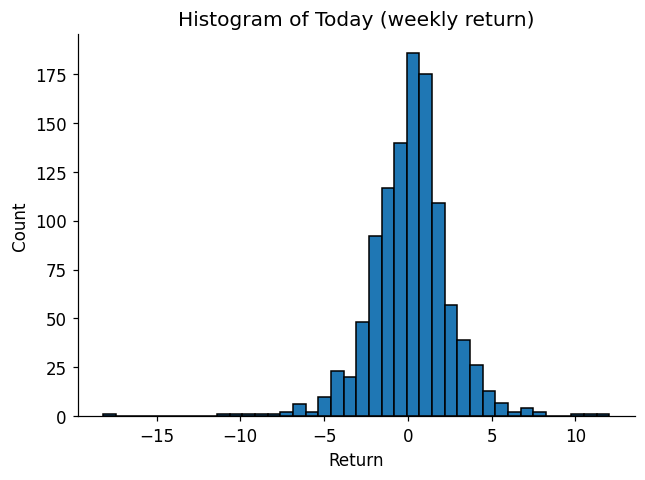

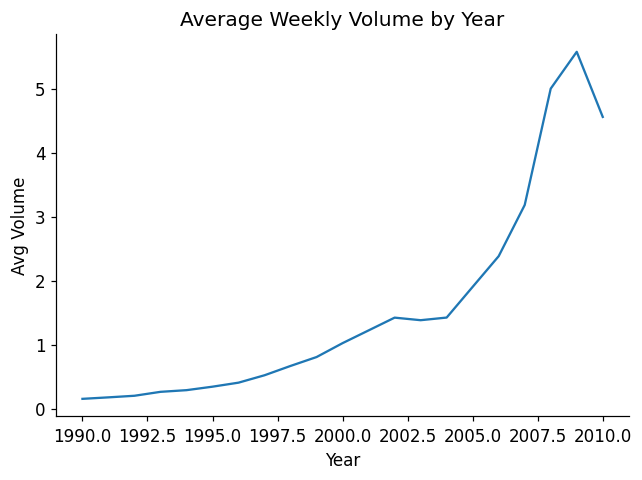

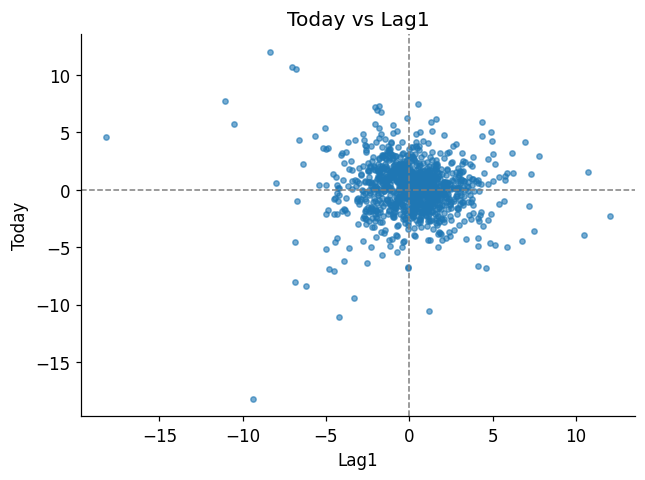

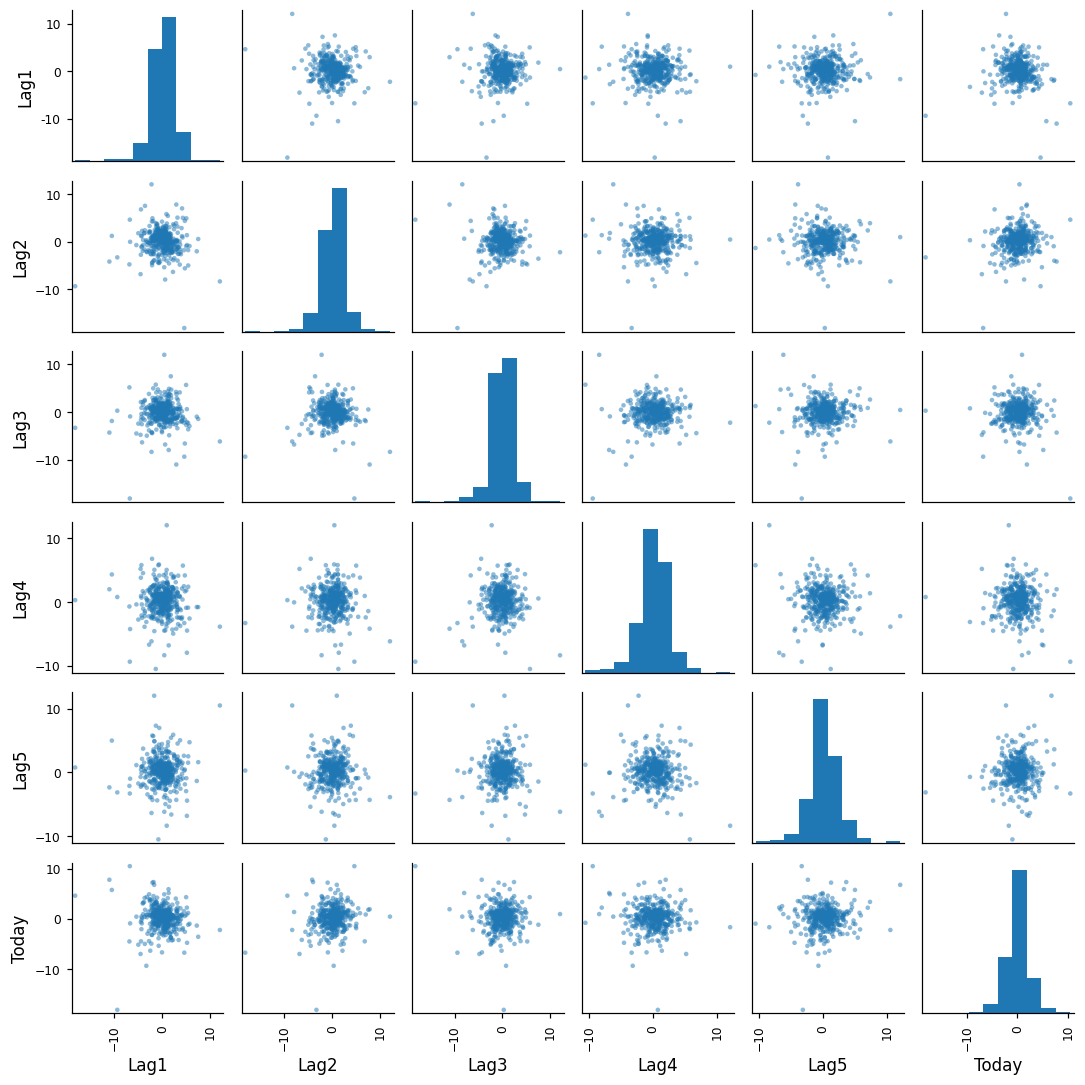

In [4]:
from pandas.plotting import scatter_matrix

# Light matplotlib styling
plt.rcParams.update({
    "figure.dpi": 110,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11,
})

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# df = Weekly   # <-- ensure your DataFrame is named `Weekly`
df = Weekly.copy()

# ---- 1) Numerical summaries ----
print("\n=== Summary (describe) ===")
print(df.describe(include="all").T.to_string())

print("\n=== Class balance (Direction) ===")
vc = df["Direction"].value_counts()
vc_norm = df["Direction"].value_counts(normalize=True).rename("proportion")
class_balance = pd.concat([vc.rename("count"), vc_norm], axis=1)
print(class_balance.to_string())

print("\n=== Correlation matrix (numeric columns) ===")
corr = df.select_dtypes(include=[np.number]).corr()
print(corr.round(4).to_string())

# ---- 2) Graphical summaries ----
# (a) Histogram of Today
plt.figure(figsize=(6, 4.5))
plt.hist(df["Today"], bins=40, edgecolor="k")
plt.title("Histogram of Today (weekly return)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# (b) Volume over time (yearly average)
plt.figure(figsize=(6, 4.5))
df.groupby("Year")["Volume"].mean().plot()
plt.title("Average Weekly Volume by Year")
plt.xlabel("Year")
plt.ylabel("Avg Volume")
plt.tight_layout()
plt.show()

# (c) Today vs Lag1
plt.figure(figsize=(6, 4.5))
plt.scatter(df["Lag1"], df["Today"], s=12, alpha=0.6)
plt.axhline(0, ls="--", lw=1, color="grey")
plt.axvline(0, ls="--", lw=1, color="grey")
plt.title("Today vs Lag1")
plt.xlabel("Lag1")
plt.ylabel("Today")
plt.tight_layout()
plt.show()

# (d) Pairwise relationships (small sample for readability)
sample = df.sample(min(400, len(df)), random_state=1)[["Lag1","Lag2","Lag3","Lag4","Lag5","Today"]]
_ = scatter_matrix(sample, figsize=(10, 10), diagonal="hist", alpha=0.5)
plt.tight_layout()
plt.show()


What patterns usually appear in this dataset

- **Returns center near zero**. The weekly returns (`Today` and the lags) are roughly symmetric and concentrated around 0, with occasional outliers.

- **Slight class imbalance**. `Direction` typically has slightly more *Up* than *Down* weeks (but not dramatically so).

- **Weak linear signal from lags**. Correlations between Today and `Lag1`–`Lag5` are very small (often close to 0), suggesting limited linear predictive power from past week returns.

- **Clear time trend in trading activity**. Volume increases over the years (plot of average `volume` by Year shows an upward trend), while returns do not show a comparable trend.

- **No obvious low-dimensional structure**. Scatterplots among Lag variables and Today look diffuse, indicating weak simple relationships.

> These observations motivate trying classification models but set expectations that simple linear relationships using only lagged returns may have limited predictive strength.

### (b) Use the full data set to perform a logistic regression with `Direction` as the response and the five lag variables plus `Volume` as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Response as binary: 1 = "Up", 0 = "Down"
df["Up"] = (df["Direction"].astype(str) == "Up").astype(int)

# Fit logistic regression with all five lags + Volume
model = smf.logit("Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume", data=df)
res = model.fit(disp=False)

# Full regression table
print(res.summary())

# Identify statistically significant predictors at alpha=0.05
alpha = 0.05
sig = res.pvalues[res.pvalues < alpha].drop("Intercept", errors="ignore")
print("\nSignificant at α = 0.05:")
print(sig.sort_values())

# (Optional) Odds ratios with 95% CIs
params = res.params
conf = res.conf_int()
or_table = pd.DataFrame({
    "OR": np.exp(params),
    "2.5%": np.exp(conf[0]),
    "97.5%": np.exp(conf[1]),
    "p-value": res.pvalues
})
display(or_table)


                           Logit Regression Results                           
Dep. Variable:                     Up   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                0.006580
Time:                        14:00:39   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.0

,OR,2.5%,97.5%,p-value
Intercept,1.3059,1.1035,1.5454,0.0019
Lag1,0.9596,0.9112,1.0105,0.1181
Lag2,1.0602,1.0058,1.1175,0.0296
Lag3,0.9841,0.9340,1.0369,0.5469
Lag4,0.9726,0.9234,1.0244,0.2937
Lag5,0.9856,0.9360,1.0379,0.5833
Volume,0.9775,0.9093,1.0508,0.5377


**Interpretation** (expected with the Weekly data): only `Lag2` typically appears statistically significant at the 5% level (positive coefficient), while `Lag1`, `Lag3`, `Lag4`, `Lag5`, and `Volume` are not statistically significant.

### (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [6]:
def calc_acc (cm, y_pred, y_test):
    acc = (y_pred == y_test).mean()
    tp = cm.loc["Up","Up"]; tn = cm.loc["Down","Down"]
    fp = cm.loc["Up","Down"]; fn = cm.loc["Down","Up"]
    tpr = tp / (tp + fn) if (tp + fn) else np.nan  # sensitivity for 'Up'
    tnr = tn / (tn + fp) if (tn + fp) else np.nan  # specificity for 'Down'

    print(f"Overall test accuracy (2009–2010): {acc:.3f}")
    print(f"Sensitivity (Up): {tpr:.3f} | Specificity (Down): {tnr:.3f}")

In [7]:
# --- fit (again, for a self-contained cell) ---
df["Up"] = (df["Direction"].astype(str) == "Up").astype(int)

logit = smf.logit("Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume", data=df).fit(disp=False)

# --- in-sample predictions, default 0.5 threshold ---
probs = logit.predict(df)
pred = pd.Series(np.where(probs >= 0.5, "Up", "Down"), index=df.index, name="Predicted")
actual = df["Direction"].astype(str)

# confusion matrix with fixed order
labels = ["Down", "Up"]
cm_log = pd.crosstab(pred, actual).reindex(index=labels, columns=labels, fill_value=0)
display(cm_log)

# accuracy and a couple of helpful rates
calc_acc (cm_log, pred, actual)

Direction,Down,Up
Predicted,,
Down,54,48
Up,430,557


Overall test accuracy (2009–2010): 0.561
Sensitivity (Up): 0.921 | Specificity (Down): 0.112


### (d) Now fit the logistic regression model using a training data period from $1990$ to $2008$, with `Lag2` as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from $2009$ and $2010$).

In [8]:
# Train: 1990–2008 | Test: 2009–2010
train_idx = df["Year"] <= 2008
test_idx  = df["Year"] >= 2009

# Fit logistic regression with Lag2 only (on training period)
logit_lag2 = smf.logit("Up ~ Lag2", data=df.loc[train_idx]).fit(disp=False)

# Predict on held-out 2009–2010
probs_test = logit_lag2.predict(df.loc[test_idx])
pred_test  = np.where(probs_test >= 0.5, "Up", "Down")

actual_test = df.loc[test_idx, "Direction"].astype(str)

# Confusion matrix (rows = predicted, cols = actual)
labels = ["Down", "Up"]
cm_log_l2 = pd.crosstab(
    pd.Series(pred_test, index=actual_test.index, name="Predicted"),
    actual_test,
).reindex(index=labels, columns=labels, fill_value=0)
display(cm_log_l2)

# Overall accuracy (fraction correct)
calc_acc (cm_log_l2, pred_test, actual_test)


Direction,Down,Up
Predicted,,
Down,9,5
Up,34,56


Overall test accuracy (2009–2010): 0.625
Sensitivity (Up): 0.918 | Specificity (Down): 0.209


### (e) Repeat (d) using LDA.

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Data
df["Direction"] = df["Direction"].astype(str)

# Train/Test split
train_idx = df["Year"] <= 2008
test_idx  = df["Year"] >= 2009

X_train = df.loc[train_idx, ["Lag2"]].to_numpy()
y_train = df.loc[train_idx, "Direction"].to_numpy()

X_test  = df.loc[test_idx, ["Lag2"]].to_numpy()
y_test  = df.loc[test_idx, "Direction"].to_numpy()

# Fit LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predict on test period (2009–2010)
y_pred = lda.predict(X_test)

# Confusion matrix (rows = predicted, cols = actual)
labels = ["Down", "Up"]
cm_lda = pd.crosstab(
    pd.Series(y_pred, index=df.index[test_idx], name="Predicted"),
    pd.Series(y_test, index=df.index[test_idx], name="Actual")
).reindex(index=labels, columns=labels, fill_value=0)
display(cm_lda)

# Overall accuracy and a couple of rates
calc_acc (cm_lda, y_pred, y_test)


Actual,Down,Up
Predicted,,
Down,9,5
Up,34,56


Overall test accuracy (2009–2010): 0.625
Sensitivity (Up): 0.918 | Specificity (Down): 0.209


### (f) Repeat (d) using QDA.

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Train/Test split
train_idx = df["Year"] <= 2008
test_idx  = df["Year"] >= 2009

X_train = df.loc[train_idx, ["Lag2"]].to_numpy()
y_train = df.loc[train_idx, "Direction"].to_numpy()

X_test  = df.loc[test_idx, ["Lag2"]].to_numpy()
y_test  = df.loc[test_idx, "Direction"].to_numpy()

# Fit QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# Predict on test set (2009–2010)
y_pred = qda.predict(X_test)

# Confusion matrix (rows = predicted, cols = actual)
labels = ["Down", "Up"]
cm_qda = pd.crosstab(
    pd.Series(y_pred, index=df.index[test_idx], name="Predicted"),
    pd.Series(y_test, index=df.index[test_idx], name="Actual")
).reindex(index=labels, columns=labels, fill_value=0)
display(cm_qda)

# Overall accuracy and helpful rates
calc_acc (cm_qda, y_pred, y_test)


Actual,Down,Up
Predicted,,
Down,0,0
Up,43,61


Overall test accuracy (2009–2010): 0.587
Sensitivity (Up): 1.000 | Specificity (Down): 0.000


### Repeat (g) using KNN with K = 1.

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# Train/Test split
train_idx = df["Year"] <= 2008
test_idx  = df["Year"] >= 2009

X_train = df.loc[train_idx, ["Lag2"]].to_numpy()
y_train = df.loc[train_idx, "Direction"].to_numpy()

X_test  = df.loc[test_idx, ["Lag2"]].to_numpy()
y_test  = df.loc[test_idx, "Direction"].to_numpy()

# Fit KNN with K=1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Predict on test period (2009–2010)
y_pred = knn.predict(X_test)

# Confusion matrix (rows = predicted, cols = actual)
labels = ["Down", "Up"]
cm_knn = pd.crosstab(
    pd.Series(y_pred, index=df.index[test_idx], name="Predicted"),
    pd.Series(y_test, index=df.index[test_idx], name="Actual")
).reindex(index=labels, columns=labels, fill_value=0)
display(cm_knn)

# Overall accuracy and helpful rates
calc_acc (cm_knn, y_pred, y_test)


Actual,Down,Up
Predicted,,
Down,22,31
Up,21,30


Overall test accuracy (2009–2010): 0.500
Sensitivity (Up): 0.492 | Specificity (Down): 0.512


### (h) Repeat (d) using naive Bayes.

In [12]:
from sklearn.naive_bayes import GaussianNB

# Train/Test split
train_idx = df["Year"] <= 2008
test_idx  = df["Year"] >= 2009

X_train = df.loc[train_idx, ["Lag2"]].to_numpy()
y_train = df.loc[train_idx, "Direction"].to_numpy()

X_test  = df.loc[test_idx, ["Lag2"]].to_numpy()
y_test  = df.loc[test_idx, "Direction"].to_numpy()

# Fit Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict on test (2009–2010)
y_pred = gnb.predict(X_test)

# Confusion matrix (rows = predicted, cols = actual)
labels = ["Down", "Up"]
cm_nb = pd.crosstab(
    pd.Series(y_pred, index=df.index[test_idx], name="Predicted"),
    pd.Series(y_test, index=df.index[test_idx], name="Actual")
).reindex(index=labels, columns=labels, fill_value=0)
display(cm_nb)

# Overall accuracy + a couple of helpful rates
calc_acc (cm_nb, y_pred, y_test)


Actual,Down,Up
Predicted,,
Down,0,0
Up,43,61


Overall test accuracy (2009–2010): 0.587
Sensitivity (Up): 1.000 | Specificity (Down): 0.000


### (i) Which of these methods appears to provide the best results on this data?

**Short answer:** By plain accuracy, **all models tie at 0.587**, which equals the “always predict Up” baseline — so none truly “wins” on accuracy.

**A better tie-breaker:** use **balanced accuracy** = (Sensitivity + Specificity)/2  
(combats the skew toward predicting *Up*).

| Model               | Sensitivity | Specificity | Balanced Acc. |
|---------------------|-------------|-------------|----------------|
| Logit (all vars)    | 0.921       | 0.112       | **0.517**      |
| Logit (Lag2 only)   | 0.918       | 0.209       | **0.564** 🔹   |
| **LDA (Lag2 only)** | 0.918       | 0.209       | **0.564** 🔹   |
| QDA (Lag2 only)     | 1.000       | 0.000       | 0.500          |
| KNN, K=1 (Lag2)     | 0.492       | 0.512       | 0.502          |
| Naive Bayes (Lag2)  | 1.000       | 0.000       | 0.500          |

**Verdict:** **LDA (Lag2)** and **Logit (Lag2)** are the best of this set (tied), offering the highest balanced accuracy and a modest boost in specificity while keeping high sensitivity.  
**Note:** Since overall accuracy matches the majority-class rate, these models have limited practical predictiveness on this test; consider threshold tuning, adding features, or alternative models (e.g., trees/ensembles) and time-series CV.


### (j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

> Train on **1990–2008**, test on **2009–2010**.  
> We try multiple predictor sets, simple transforms/interactions, and a K grid for KNN.  
> We report per-method winners and the **overall best** by **balanced accuracy** $(\text{TPR}+\text{TNR})/2$, along with the confusion matrix.



In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# ---------------------------
# 1) Data prep
# ---------------------------
df = Weekly.copy()
df = df.assign(
    Direction=df["Direction"].astype(str),
    Up=(df["Direction"].astype(str)=="Up").astype(int),
    Lag2_sq=df["Lag2"]**2,
    Lag1xLag2=df["Lag1"]*df["Lag2"],
    logV=np.log(df["Volume"].clip(lower=1e-12)),
    Lag2_pos=(df["Lag2"]>0).astype(int)
)

train_idx = df["Year"] <= 2008
test_idx  = df["Year"] >= 2009

y_train = df.loc[train_idx, "Direction"].to_numpy()
y_test  = df.loc[test_idx,  "Direction"].to_numpy()
y_train_bin = (y_train == "Up").astype(int)
y_test_bin  = (y_test  == "Up").astype(int)

# Candidate feature sets
feature_sets = {
    "Lag2"              : ["Lag2"],
    "Lag2 + Lag1"       : ["Lag2","Lag1"],
    "Lag2 + Lag2^2"     : ["Lag2","Lag2_sq"],
    "Lag2 + Lag1:Lag2"  : ["Lag2","Lag1","Lag1xLag2"],
    "Lags1-5"           : ["Lag1","Lag2","Lag3","Lag4","Lag5"],
    "Lags1-5 + logV"    : ["Lag1","Lag2","Lag3","Lag4","Lag5","logV"],
    "Lag2 + logV"       : ["Lag2","logV"],
    "Lag2_pos (indicator)": ["Lag2_pos"],        # step function on Lag2
}

# Helper to compute metrics from a confusion matrix
def summarize(cm, labels=("Down","Up")):
    # cm rows = pred, cols = actual, order by labels
    tn = cm[0,0]; fp = cm[0,1]
    fn = cm[1,0]; tp = cm[1,1]
    total = cm.sum()
    acc = (tp + tn) / total if total else np.nan
    tpr = tp / (tp + fn) if (tp + fn) else np.nan   # sensitivity for Up
    tnr = tn / (tn + fp) if (tn + fp) else np.nan   # specificity for Down
    bal = 0.5*(tpr + tnr) if np.isfinite(tpr) and np.isfinite(tnr) else np.nan
    return dict(acc=acc, tpr=tpr, tnr=tnr, bal=bal, tp=tp, tn=tn, fp=fp, fn=fn)

def confmat_df(cm, labels=("Down","Up")):
    return pd.DataFrame(cm, index=pd.Index(labels, name="Predicted"), columns=pd.Index(labels, name="Actual"))

# Containers for best per method
best = {}   # method -> dict with keys: name, Xcols, cm, metrics, extra (e.g., K)
overall_best = None

# ---------------------------
# 2) LOGISTIC REGRESSION (GLM Binomial with logit link)
# ---------------------------
for name, cols in feature_sets.items():
    X_train = df.loc[train_idx, cols]
    X_test  = df.loc[test_idx,  cols]

    X_train_sm = sm.add_constant(X_train)
    X_test_sm  = sm.add_constant(X_test)

    # Fit GLM Binomial (more stable than Logit for edge cases)
    glm = sm.GLM(y_train_bin, X_train_sm, family=sm.families.Binomial())
    res = glm.fit()

    # Predict with default 0.5 threshold
    p_test = res.predict(X_test_sm)
    y_pred = np.where(p_test >= 0.5, "Up", "Down")

    cm = confusion_matrix(y_test, y_pred, labels=["Down","Up"])
    metrics = summarize(cm)
    rec = dict(method="Logit", name=name, Xcols=cols, cm=cm, metrics=metrics)

    if "Logit" not in best or metrics["bal"] > best["Logit"]["metrics"]["bal"]:
        best["Logit"] = rec

# ---------------------------
# 3) LDA
# ---------------------------
for name, cols in feature_sets.items():
    X_train = df.loc[train_idx, cols].to_numpy()
    X_test  = df.loc[test_idx,  cols].to_numpy()
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=["Down","Up"])
    metrics = summarize(cm)
    rec = dict(method="LDA", name=name, Xcols=cols, cm=cm, metrics=metrics)

    if "LDA" not in best or metrics["bal"] > best["LDA"]["metrics"]["bal"]:
        best["LDA"] = rec

# ---------------------------
# 4) QDA
# ---------------------------
for name, cols in feature_sets.items():
    X_train = df.loc[train_idx, cols].to_numpy()
    X_test  = df.loc[test_idx,  cols].to_numpy()
    qda = QuadraticDiscriminantAnalysis()
    # QDA can fail if a class has 0 variance along a feature; guard with try
    try:
        qda.fit(X_train, y_train)
        y_pred = qda.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=["Down","Up"])
        metrics = summarize(cm)
        rec = dict(method="QDA", name=name, Xcols=cols, cm=cm, metrics=metrics)
        if "QDA" not in best or metrics["bal"] > best["QDA"]["metrics"]["bal"]:
            best["QDA"] = rec
    except Exception as e:
        pass  # skip problematic specs

# ---------------------------
# 5) Gaussian Naive Bayes
# ---------------------------
for name, cols in feature_sets.items():
    X_train = df.loc[train_idx, cols].to_numpy()
    X_test  = df.loc[test_idx,  cols].to_numpy()
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=["Down","Up"])
    metrics = summarize(cm)
    rec = dict(method="NaiveBayes", name=name, Xcols=cols, cm=cm, metrics=metrics)

    if "NaiveBayes" not in best or metrics["bal"] > best["NaiveBayes"]["metrics"]["bal"]:
        best["NaiveBayes"] = rec

# ---------------------------
# 6) KNN (with scaling) — search K
# ---------------------------
K_grid = [1, 3, 5, 7, 9, 11, 15, 21, 31]

for name, cols in feature_sets.items():
    X_train = df.loc[train_idx, cols].to_numpy()
    X_test  = df.loc[test_idx,  cols].to_numpy()

    for K in K_grid:
        knn = make_pipeline(StandardScaler(with_mean=True, with_std=True), KNeighborsClassifier(n_neighbors=K))
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=["Down","Up"])
        metrics = summarize(cm)
        rec = dict(method="KNN", name=f"{name} | K={K}", Xcols=cols, cm=cm, metrics=metrics, K=K)

        if "KNN" not in best or metrics["bal"] > best["KNN"]["metrics"]["bal"]:
            best["KNN"] = rec

# ---------------------------
# 7) Display per-method best and pick overall best
# ---------------------------
rows = []
for method, rec in best.items():
    m = rec["metrics"]
    rows.append([
        method,
        rec["name"],
        f"{m['acc']:.3f}",
        f"{m['tpr']:.3f}",
        f"{m['tnr']:.3f}",
        f"{m['bal']:.3f}"
    ])
    if (overall_best is None) or (m["bal"] > overall_best["metrics"]["bal"]):
        overall_best = rec

summary_df = pd.DataFrame(rows, columns=["Method","Best feature set / K","Accuracy","Sensitivity (Up)","Specificity (Down)","Balanced Acc."])
display(summary_df.sort_values("Balanced Acc.", ascending=False, key=lambda s: s.astype(float)))

print("\n🏆 Best overall by Balanced Accuracy:")
m = overall_best["metrics"]
print(f"- Method: {overall_best['method']}")
print(f"- Features: {overall_best['name']} -> {overall_best['Xcols']}")
print(f"- Accuracy: {m['acc']:.3f} | Sensitivity (Up): {m['tpr']:.3f} | Specificity (Down): {m['tnr']:.3f} | Balanced Acc.: {m['bal']:.3f}")

print("\nConfusion Matrix (rows=Pred, cols=Actual):")
display(confmat_df(overall_best["cm"]))


,Method,Best feature set / K,Accuracy,Sensitivity (Up),Specificity (Down),Balanced Acc.
4,KNN,Lag2 + logV | K=3,0.587,0.541,0.651,0.596
0,Logit,Lag2,0.625,0.918,0.209,0.564
1,LDA,Lag2,0.625,0.918,0.209,0.564
2,QDA,Lag2 + Lag2^2,0.625,0.951,0.163,0.557
3,NaiveBayes,Lag2 + logV,0.548,0.541,0.558,0.550



🏆 Best overall by Balanced Accuracy:
- Method: KNN
- Features: Lag2 + logV | K=3 -> ['Lag2', 'logV']
- Accuracy: 0.587 | Sensitivity (Up): 0.541 | Specificity (Down): 0.651 | Balanced Acc.: 0.596

Confusion Matrix (rows=Pred, cols=Actual):


Actual,Down,Up
Predicted,,
Down,28,15
Up,28,33
